In [1]:
import cv2

import sys

import numpy as np

import pandas as pd
import scipy
import scipy.sparse
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from numba import jit

import concurrent.futures

# import fall color from cooltools
import cooltools.lib.plotting
import multiprocessing as mp
from scipy.stats import mannwhitneyu

In [2]:
from coolbox.utilities.genome import GenomeRange
from coolbox.api import *
import re
import matplotlib.pyplot as plt

In [3]:
sys.path.append("/shareb/zliu/analysis/hires_gastrulation/")
sys.path.append("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/")

In [4]:
tad_loc = pd.read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/halftime/DI_tad_location.csv')

In [6]:
heatmap_res = pd.read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/halftime/DI_heatmap_res.csv').query('halftime != -1')

In [7]:
heatmap_res.shape

(180977, 15)

In [8]:
0.25*180977

45244.25

In [9]:
heatmap_res = heatmap_res.sort_values('p_diff').head(45244)

In [10]:
0.75*45244

33933.0

In [11]:
heatmap_res = heatmap_res.sort_values('sqrtRSS').head(33933)

In [21]:
temp = pd.read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c5_B6_XCI_diff.csv')
temp = temp[['index1','index2']]
df = heatmap_res[['index1','index2','halftime']]
temp = temp.merge(df, on=['index1', 'index2'], how='left')
pivot_table = temp.pivot('index1', 'index2', 'halftime')

In [31]:
pivot_table[np.isnan(pivot_table)] = 0

In [32]:
halftime_mtx = pivot_table + pivot_table.T
halftime_mtx = np.where(halftime_mtx == 0, np.nan, halftime_mtx)

# pile up

In [33]:
my_tad = pd.read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv', index_col = 0)
my_tad

,index,start,end,distance,mask
0,0,269,288,19,14
1,1,288,311,23,24
2,2,311,327,16,17
3,3,327,368,41,41
4,4,368,386,18,19
...,...,...,...,...,...
107,128,8363,8447,84,85
108,129,8447,8487,40,41
109,130,8487,8499,12,12
110,131,5173,5185,12,12


In [34]:
my_tad = pd.read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv', index_col = 0)
tad_sel = my_tad.query('index != 131')
# .query('index != 132').query('index != 130').query('index != 0')
tad_sel = tad_sel.query('distance < 100')

In [35]:
tad_sel

,index,start,end,distance,mask
0,0,269,288,19,14
1,1,288,311,23,24
2,2,311,327,16,17
3,3,327,368,41,41
4,4,368,386,18,19
...,...,...,...,...,...
106,127,8332,8363,31,32
107,128,8363,8447,84,85
108,129,8447,8487,40,41
109,130,8487,8499,12,12


In [36]:
# from tqdm import tqdm
# mats = []
# for i in tqdm(tad_sel.values):
#     length = i[3]
#     mati = halftime_mtx[i[1]-length:i[2]+length,i[1]-length:i[2]+length]
#     mati = (mati - np.nanmean(mati))/np.nanstd(mati)
#     mats.append(mati)

np.random.seed(3)
from tqdm import tqdm
mats = []
for i in tqdm(tad_sel.values):
    length = i[3]
    mati = halftime_mtx[i[1]:i[2]+1,i[1]:i[2]+1]
    if np.random.rand() > 0.5:
        mati = np.fliplr(np.transpose(np.fliplr(mati)))

    mati = mati / np.nanmean(mati)
    mats.append(mati)

100%|██████████| 100/100 [00:00<00:00, 6084.79it/s]


In [37]:
resize_mats = []
for i in tqdm(mats):
    resize_mats.append(cv2.resize(i,(45,45), interpolation = cv2.INTER_NEAREST))
pmat = np.nanmean(np.array(resize_mats),axis=0)

100%|██████████| 100/100 [00:00<00:00, 32152.58it/s]


In [38]:
stacked_mats = np.stack(resize_mats)
non_nan_counts = np.sum(~np.isnan(stacked_mats), axis=0)

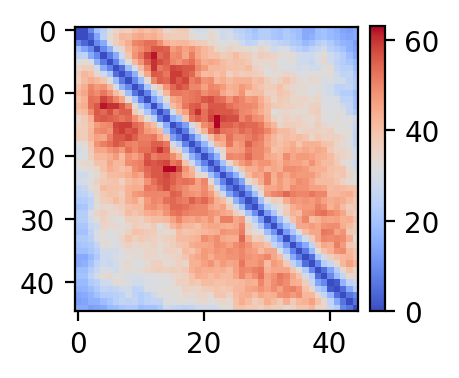

In [39]:
cmap = plt.cm.coolwarm
cmap.set_bad(color='#f0f0f0')
plt.figure(figsize=(2, 2),dpi=200, facecolor='white')
im2 = plt.imshow(non_nan_counts, cmap=cmap)
plt.colorbar(im2,fraction=0.046, pad=0.04)

([], [])

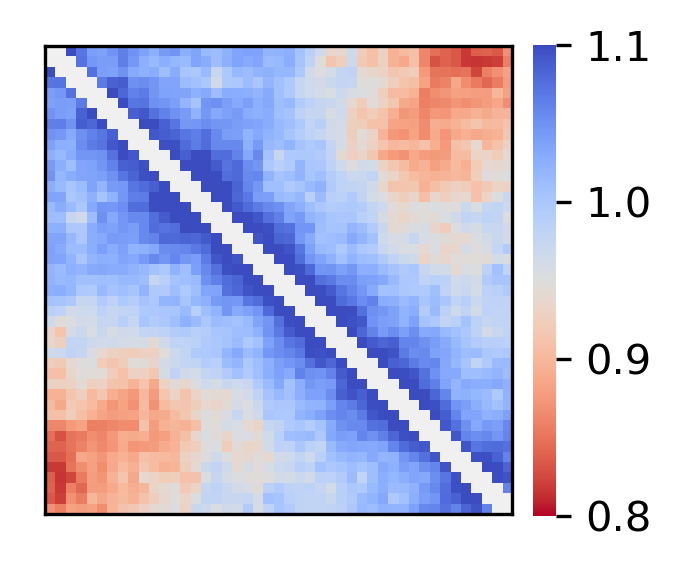

In [40]:
plot = pmat.copy()
plot[non_nan_counts <= 2] = np.nan

cmap = plt.cm.coolwarm_r
cmap.set_bad(color='#f0f0f0')

# 把对角线上前后一格的值设置为nan
for i in range(1, 45):
    plot[i, i] = np.nan
    plot[i-1, i] = np.nan
    plot[i, i-1] = np.nan

plt.figure(figsize=(2.2, 2.2),dpi=300, facecolor='white')
im2 = plt.imshow(plot, cmap=cmap, vmin = 0.8, vmax = 1.1)
cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
cbar.outline.set_visible(False)
# 不显示x,y轴的刻度
plt.xticks([])
plt.yticks([])
# plt.title('After flipping')
# plt.savefig('/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4H_pileup_halftime.pdf', format='pdf', bbox_inches='tight')